In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from nltk.stem import WordNetLemmatizer, PorterStemmer
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import DBSCAN, KMeans
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import unidecode
import nltk
import json
import sys
import re
import os

In [2]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrateur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrateur\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrateur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Export all data into JSON

In [4]:
# add the parent directory of main.py to Python path to enable import modules from the wikibase package.
notebook_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_path, '../../'))
sys.path.insert(0, parent_dir)

from wikibase_injector.data_formatter.formatter.data_clic_csv import retrieve_data as csv_retrieve_data 

_, data_csv = csv_retrieve_data(file_path="../../../data/monuments_historiques_departement42_2023-02-11.csv")

# Writing data to a new JSON file
with open('test.json', 'w') as f:
    json.dump(data_csv, f, indent=2)

Current Path: c:\Users\Administrateur\Documents\GitHub\WikiStone\wikibase\wikibase_injector\classifier


## Clustering

#### Pre-processing data

The `preprocess` function takes in a `text` parameter and an optional `label` parameter. It first removes special characters and converts text to lowercase. The function then tokenizes the text and applies lemmatization and stemming to the tokens. Stopwords are removed, and the function returns either a list of cleaned tokens that match the keywords list or a list of all cleaned tokens in the case of `label=True`.

The code also preprocesses each keyword in the keywords list using the `preprocess` function and assigns the preprocessed list of keywords to the `keywords` variable.

In [6]:
# Initialization of preprocessing tools
stop_words = set(stopwords.words('french'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# List of keywords
keywords = ['eglise', 'musee', 'maison', 'immeuble', 'Chapelle', 'château']

# Data preprocessing function
def preprocess(text, label=False):
    text = unidecode.unidecode(text) # Remove accents
    text = re.sub(r'[^\w\s]', '', text) # Remove special characters
    text = text.lower() # Convert to lowercase

    tokens = nltk.word_tokenize(text) # Tokenization
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens] # Lemmatization
    stemmed_tokens = [stemmer.stem(token) for token in lemmatized_tokens] # Stemming
    stop_tokens = [token for token in stemmed_tokens if token not in stop_words] # Remove stop words

    if not label:
        # Return keywords if present, otherwise return stop_tokens
        cleaned_tokens = [token for token in stop_tokens if token in keywords] or stop_tokens
    else:
        cleaned_tokens = stop_tokens
    
    text = ' '.join(cleaned_tokens) # Reassemble preprocessed text
    return text

keywords = [preprocess(keyword, label=True) for keyword in keywords]

In [40]:
# Loading data from JSON file
with open('./donnees_non_clusterisees.json', 'r') as f:
    data = json.load(f)

# Extracting the "name" column
names = [d['name'] for d in data]

# Applying the preprocess function to monument names and descriptions
clean_names = [preprocess(name) for name in names]

#### Creation of the TF-IDF matrix

We create a TfidfVectorizer object from the scikit-learn library, which is used to convert a collection of raw documents (in our case, a list of strings `clean_names`) into a matrix of TF-IDF features. 

**TF-IDF** stands for **Term Frequency-Inverse Document Frequency**, and it is a numerical statistic that reflects how important a word is to a document in a collection or corpus. It is often used as a weighting factor in information retrieval and text mining.

The `fit_transform()` method of the vectorizer object fits the vectorizer to the `clean_names` data and transforms it into a sparse matrix of TF-IDF features. The resulting matrix is assigned to the variable `tfidf_matrix`. 

Finally, the `toarray()` method is called on the `tfidf_matrix` to convert it into a dense matrix of TF-IDF features, which is then reassigned to the `tfidf_matrix` variable.


In [41]:
# create a TfidfVectorizer object
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(clean_names)
tfidf_matrix = tfidf_matrix.toarray()

#### Creation of the Word2Vec matrix

A Word2Vec model is trained on ``processed_data`` using the ``Word2Vec()`` function from the gensim library. The resulting model is assigned to the variable ``model``. The vector_size parameter specifies the size of the word vectors, ``window`` specifies the maximum distance between the current and predicted word within a sentence, ``min_count`` specifies the minimum number of occurrences of a word for it to be included in the vocabulary, and ``workers`` specifies the number of worker threads to train the model.

Next, a matrix of semantic representation is created with the shape ``(len(processed_data), vector_size)``, where each row represents a sentence in processed_data, and each column represents a dimension in the word vector space.

The matrix is populated by iterating over each sentence in ``processed_data`` and summing the word vectors for each word in the sentence using the trained ``model``. The resulting sum is divided by the length of the sentence to get the average word vector. The resulting matrix is assigned to the variable ``representation_matrix``.

To simplify the use of the matrix of word vectors learned by the Word2Vec model we assig it to the ``tfidf_matrix`` variable.

In [ ]:
vector_size = len(data)
processed_data = clean_names

# train a Word2Vec model on the processed data
model = Word2Vec(processed_data, vector_size=vector_size, window=5, min_count=1, workers=4)

# iterate over each sentence in processed_data and populate the representation matrix with the word vectors
representation_matrix = np.zeros((len(processed_data), vector_size))
for i, sentence in enumerate(processed_data):
    for word in sentence:
        representation_matrix[i] += model.wv[word]
    representation_matrix[i] /= len(sentence)

# get the matrix of word vectors learned by the Word2Vec model and transpose it
tfidf_matrix = model.wv.vectors.transpose()

### Nombre de Cluster Optimal

#### Elbow Method

We creates a KMeans object with a random seed of 42 and 10 initializations. A KElbowVisualizer object is created with the KMeans model and a range of k values (1 to 20) to test for the optimal number of clusters. 

The fit() method of the visualizer object is called with the TF-IDF matrix as input, which fits the KMeans model to the data and computes the distortion score for each value of k. 
We can then read the elbow curve to determine the optimal number of clusters for the data.

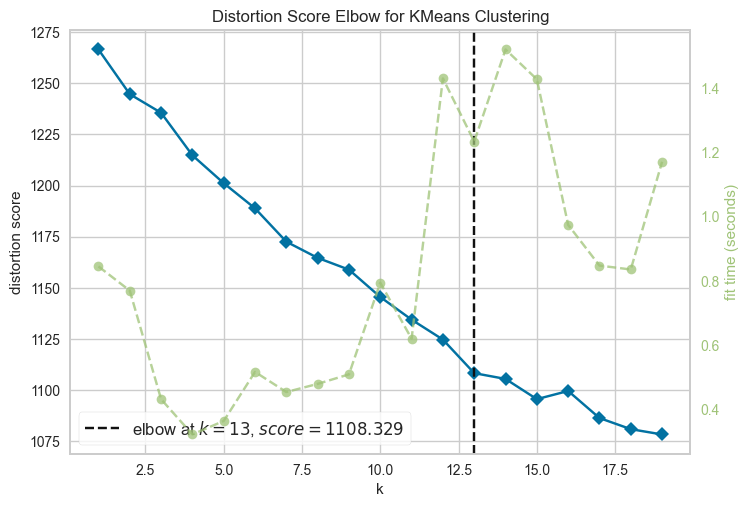

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
# create a KMeans object with a random seed of 42 and 10 initializations
model = KMeans(random_state=42, n_init=10)

# create a KElbowVisualizer object with the model and a range of k values
visualizer = KElbowVisualizer(model, k=(1, 20))

# fit the visualizer to the TF-IDF matrix and plot the elbow curve
visualizer.fit(tfidf_matrix)
visualizer.show()

## Clustering

In [48]:
n_clusters = 13 # Number of cluster

### Agglomerative Clustering (hierarchical clustering)

``AgglomerativeClustering`` is a hierarchical clustering algorithm that works by iteratively merging smaller clusters into larger ones. Starting with each data point as its own cluster, the algorithm then identifies the two closest clusters and merges them into a larger cluster. This process is repeated until a desired number of clusters is reached.

The ``AgglomerativeClustering`` function in scikit-learn takes several parameters, including the number of clusters to form, the linkage method used to determine the distance between clusters, and the distance metric used to measure the distance between individual data points.

Here, the ``AgglomerativeClustering`` algorithm is used to cluster the ``tfidf_matrix`` into ``n_clusters`` clusters, with linkage method set to 'ward' and distance metric set to 'euclidean'. The resulting cluster labels are then assigned to the data points in ``data``, and a new file is written with the updated data including the cluster labels and the coordinates of the cluster centers.

In [ ]:
# Define AgglomerativeClustering object with specified parameters perform hierarchical clustering
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', metric='euclidean').fit(tfidf_matrix)

# Find the fusion heights of the clustering hierarchy
Z = linkage(tfidf_matrix, method='ward')

# Find the indices of the samples in each cluster
# using the maxclust criterion to form n_clusters clusters
labels = fcluster(Z, n_clusters, criterion='maxclust')

# Find the cluster centers by computing the mean vector of all
# feature vectors in each cluster
cluster_centers = []
for i in range(1, n_clusters+1):
    idx = np.where(labels == i)[0]
    center = np.mean(tfidf_matrix[idx], axis=0)
    cluster_centers.append(center)

# Convert cluster_centers list to a numpy array
cluster_centers = np.vstack(cluster_centers)

# Compute the distances between the cluster centers and the points in tfidf_matrix
distances = euclidean_distances(tfidf_matrix, cluster_centers)

# Find the index of the closest cluster center for each point
cluster_labels = distances.argmin(axis=1)

# Add a new column to store the cluster labels associated with the monument names
for i in range(len(data)):
    data[i]['label'] = int(cluster_labels[i])

### K-Means Clustering
``K-means`` clustering is a type of unsupervised learning algorithm used to group data points into clusters based on their similarity. The algorithm works by randomly selecting k initial centroids, assigning each data point to the nearest centroid, and then recalculating the centroid of each cluster. This process is repeated iteratively until the centroids no longer change significantly or a maximum number of iterations is reached.

Here, the KMeans algorithm from the sklearn library is used to perform ``K-means`` clustering on a ``TF-IDF`` matrix of preprocessed data. The algorithm is initialized with a specified number of clusters (`n_clusters`), maximum number of iterations (`max_iter`), and random seed for reproducibility. The resulting cluster labels are added to the original data for further analysis.

In [49]:
# Specify the maximum number of iteration
max_iter = 500

# Init the Kmeans
kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=42, n_init=10).fit(tfidf_matrix)

# Get the labels
cluster_labels = kmeans.labels_

# add the labels to the data
for i in range(len(data)):
    data[i]['label'] = int(cluster_labels[i])

### DBSCAN Clustering

``DBSCAN`` (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm that groups together points that are close to each other based on a specified distance metric. It requires two parameters, eps and min_samples. 

- eps: the maximum distance between two points for them to be considered as part of the same cluster
- min_samples: the minimum number of points required to form a dense region (i.e., a cluster)

``DBSCAN`` is particularly useful for datasets with complex geometries and varying densities. It is also robust to outliers and noise in the data.

Here, we use ``DBSCAN`` to cluster the ``TF-IDF matrix`` into groups based on the distance between the samples. The resulting labels are added to the original data.

In [ ]:
eps = 0.8 # Maximum distance between samples to be considered as belonging to the same cluster
min_samples = 4 # Minimum number of samples to form a cluster

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(tfidf_matrix)

# add the labels to the data
for i in range(len(data)):
    data[i]['label'] = int(cluster_labels[i])

## PLOT Monument / Label

### Number of monuments by cluster

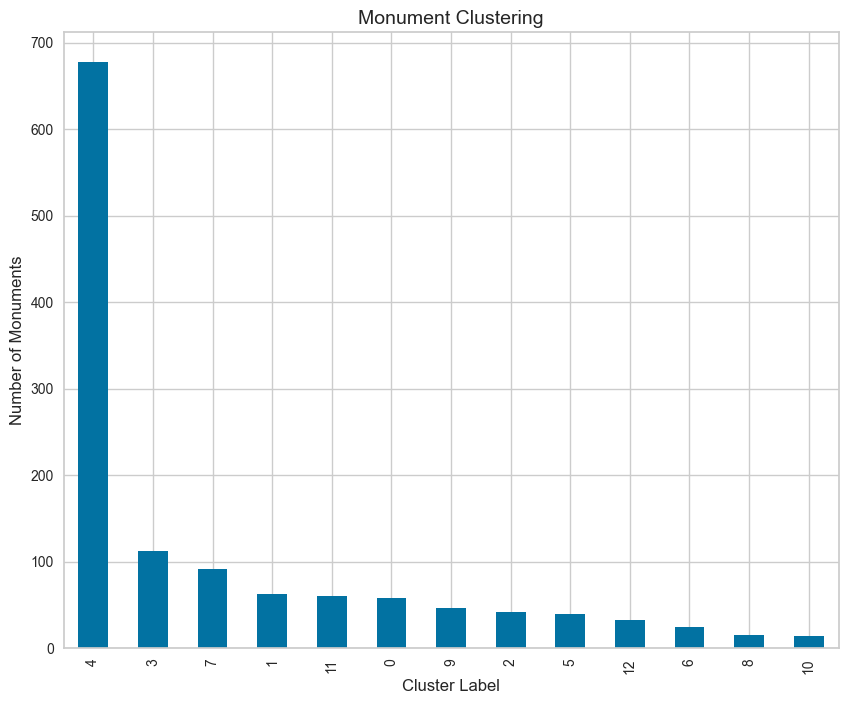

In [50]:

labels = [d['label'] for d in data]
counts = pd.Series(labels).value_counts()

fig, ax = plt.subplots(figsize=(10, 8))
counts.plot(kind='bar', ax=ax)

# Config axis and title
ax.set_xlabel('Cluster Label', fontsize=12)
ax.set_ylabel('Number of Monuments', fontsize=12)
ax.set_title('Monument Clustering', fontsize=14)

# Plot 
plt.show()

### Représentation des monuments/Cluster 

In [51]:
# Retrieve the label and names of the monuments
labels = [d['label'] for d in data]
names = [d['name'] for d in data]

# Create the fig
fig = go.Figure()

# Adding points to the figure with the names of the monuments by hovering over the points.
fig.add_trace(go.Scatter(x=labels, y=list(range(len(data))),
                    mode='markers',
                    text=names,
                    hovertemplate='<b>%{text}</b>',
                    marker=dict(
                        size=10,
                        color=labels,
                        colorscale='Viridis',
                        line_width=0.5)))

# Config / title
fig.update_layout(title='Monument Clustering',
                xaxis_title='Cluster Label',
                yaxis_title='Monument',
                margin=dict(l=50, r=50, t=50, b=50))

fig.update_layout(height=800)

# plot
fig.show()

In [39]:
ignore_labels = [0, 5]
INC = 8

# We avoid importing data with incorrect labels
data_cleaned = [d for d in data if d['label'] not in ignore_labels]
data_cleaned = [d for d in data if d['label'] not in ignore_labels]
for d in data_cleaned:
    if d['label'] not in ignore_labels:
        d['label'] += INC

data_not_cleaned = [d for d in data if d['label'] in ignore_labels]

# Load the data from the JSON file
with open("./donnees_clusterisees.json", 'r') as f:
    data_clustered = json.load(f)

data_clustered.extend(data_cleaned)

# Write the labelised data
with open('./donnees_clusterisees.json', 'w') as f:
    json.dump(data_clustered, f, indent=2)
    
# Write the data that has not been labeled.
with open('./donnees_non_clusterisees.json', 'w') as f:
    json.dump(data_not_cleaned, f, indent=2)
